## 0. Importing Necessary Libraries & Dependencies

In [1]:
# Importing Libraries
import torch
from torch import nn

print(f"PyTroch Version: {torch.__version__}")

# Setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

PyTroch Version: 2.5.1+cu121
Device: cpu


In [2]:
!nvidia-smi # if you have a gpu

/bin/bash: line 1: nvidia-smi: command not found


## 1. Get Data

In [3]:
import requests
import zipfile
from pathlib import Path

# Set up path to datafolder
data_path = Path("data/")
image_data_path = data_path / "fruits_dataset"

# If the fruits_dataset folder doesn't exists, download it and prepare it.....
if image_data_path.is_dir():
  print(f"{image_data_path} directory already exists! Skipping download......")
else:
  print(f"{image_data_path} doesn't exists, creating one......")
  image_data_path.mkdir(parents=True, exist_ok=True)

# Download fruits_dataset
with open(data_path / "fruits_dataset.zip", "wb") as f:
  request = requests.get("https://github.com/nepal-manjil32/pytorch-models/raw/main/datasets/fruits_dataset.zip")
  print("Downloading fruits_classification dataset......")
  f.write(request.content)

# Unzip fruits_classification dataset
with zipfile.ZipFile(data_path / "fruits_dataset.zip", "r") as zip_ref:
  print("Unzipping fruits_dataset.zip......")
  zip_ref.extractall(image_data_path)

data/fruits_dataset directory already exists! Skipping download......
Unzipping fruits_dataset.zip......


## 2. Data Exploaration & Preparation

In [4]:
import os
def wal_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)}images in '{dirpath}")

wal_through_dir(image_data_path)

There are 2 directories and 0images in 'data/fruits_dataset
There are 1 directories and 0images in 'data/fruits_dataset/__MACOSX
There are 2 directories and 3images in 'data/fruits_dataset/__MACOSX/fruits_dataset
There are 10 directories and 10images in 'data/fruits_dataset/__MACOSX/fruits_dataset/test
There are 0 directories and 106images in 'data/fruits_dataset/__MACOSX/fruits_dataset/test/banana
There are 0 directories and 105images in 'data/fruits_dataset/__MACOSX/fruits_dataset/test/kiwi
There are 0 directories and 97images in 'data/fruits_dataset/__MACOSX/fruits_dataset/test/orange
There are 0 directories and 89images in 'data/fruits_dataset/__MACOSX/fruits_dataset/test/apple
There are 0 directories and 105images in 'data/fruits_dataset/__MACOSX/fruits_dataset/test/pinenapple
There are 0 directories and 105images in 'data/fruits_dataset/__MACOSX/fruits_dataset/test/watermelon
There are 0 directories and 105images in 'data/fruits_dataset/__MACOSX/fruits_dataset/test/avocado
There 

In [5]:
# Setup training and testing paths
train_dir = image_data_path / "__MACOSX/train"
test_dir = image_data_path / "__MACOSX/test"

train_dir, test_dir

(PosixPath('data/fruits_dataset/__MACOSX/train'),
 PosixPath('data/fruits_dataset/__MACOSX/test'))

### 2.1 Visualization

In [6]:
image_data_path

PosixPath('data/fruits_dataset')

Random Image Path: data/fruits_dataset/fruits_dataset/train/avocado/img_2951.jpeg
Image Class: avocado
Image Height: 225
Image Width: 225


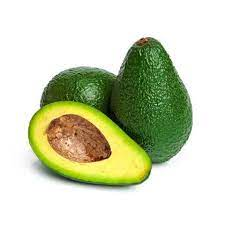

In [7]:
##-- Visualizing using PIL --##
import random
from pathlib import Path
from PIL import Image

random.seed(42)

# 1. Get all image paths
image_path_list = list(image_data_path.glob("*/*/*/*.jpeg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class from the path name
image_class = random_image_path.parent.stem

# 4. Open the image
img = Image.open(random_image_path)

print(f"Random Image Path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

(-0.5, 224.5, 224.5, -0.5)

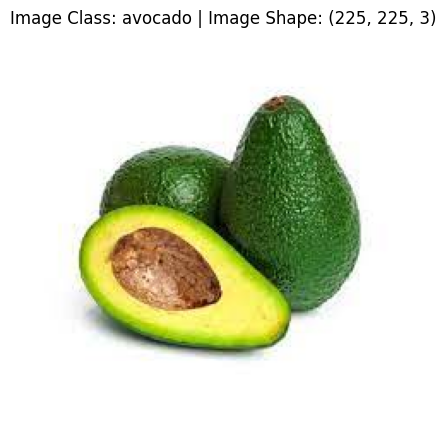

In [8]:
##-- Visulaizing using matplotlib --##
import numpy as np
import matplotlib.pyplot as plt

# Turn the images into an array
img_as_array = np.asarray(img)

plt.figure(figsize=(6,5))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image Shape: {img_as_array.shape}")
plt.axis(False)

## 3. Transforming Data

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
##-- Image transformation script --##
train_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [11]:
transformed_image = train_image_transform(img)

In [12]:
##-- Function to visualize original and transformed image --##
def plot_transformed_image(image_paths: list, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for img_pth in random_image_paths:
    with Image.open(img_pth) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\n{f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1,2,0) # [color_channels, height, width] -> [height, width, color_channels]
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\n{transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {img_pth.parent.stem}", fontsize=16)

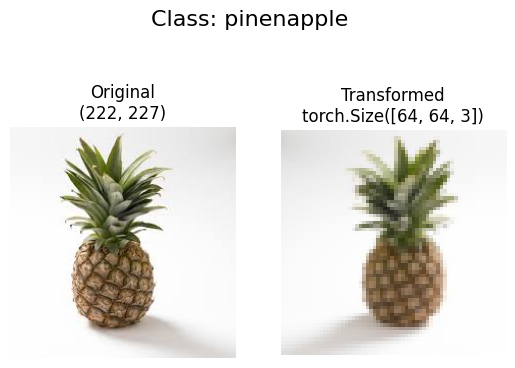

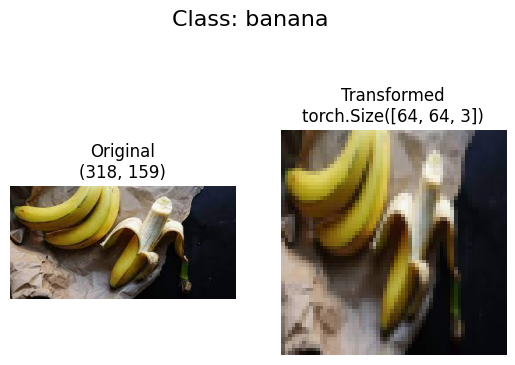

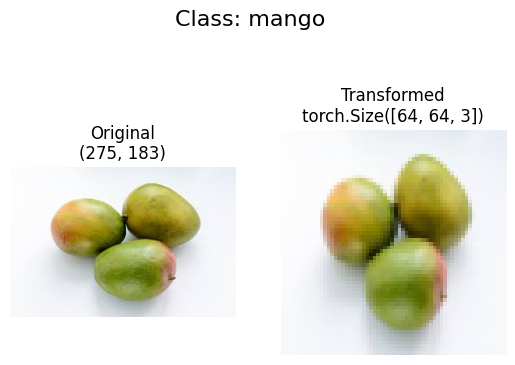

In [13]:
plot_transformed_image(image_paths=image_path_list, transform=train_image_transform, n=3)

## 4. Loading Image Data Using ImageFolder

We can load image classification data uing `torch.vision.datasets.ImageFolder`

**Note: **Since our dataset in the standard image classification format, we can use one of `torchvision.datasets` prebuilt functions

In [14]:
# _MACOSX is causing error and the actual path appears like this
train_dir = 'data/fruits_dataset/fruits_dataset/train'
test_dir = 'data/fruits_dataset/fruits_dataset/test'

In [15]:
train_dir, test_dir

('data/fruits_dataset/fruits_dataset/train',
 'data/fruits_dataset/fruits_dataset/test')

In [16]:
# Using ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_image_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_image_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 2301
     Root location: data/fruits_dataset/fruits_dataset/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1025
     Root location: data/fruits_dataset/fruits_dataset/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [17]:
# Get class names
class_names = train_data.classes
class_names

['apple',
 'avocado',
 'banana',
 'cherry',
 'kiwi',
 'mango',
 'orange',
 'pinenapple',
 'strawberries',
 'watermelon']

In [18]:
# Get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'apple': 0,
 'avocado': 1,
 'banana': 2,
 'cherry': 3,
 'kiwi': 4,
 'mango': 5,
 'orange': 6,
 'pinenapple': 7,
 'strawberries': 8,
 'watermelon': 9}

In [19]:
# Index on the train data to get a single image and label
img, label = train_data[0][0], train_data[0][1]
img

tensor([[[0.0980, 0.0941, 0.0902,  ..., 0.0078, 0.0078, 0.0078],
         [0.0980, 0.0941, 0.0902,  ..., 0.0078, 0.0078, 0.0078],
         [0.0980, 0.0941, 0.0902,  ..., 0.0078, 0.0078, 0.0078],
         ...,
         [0.8275, 0.7961, 0.6549,  ..., 0.7647, 0.7451, 0.7294],
         [0.8314, 0.8078, 0.7686,  ..., 0.8549, 0.8471, 0.7961],
         [0.8941, 0.8863, 0.8902,  ..., 0.9059, 0.8980, 0.8784]],

        [[0.0784, 0.0745, 0.0706,  ..., 0.0000, 0.0000, 0.0000],
         [0.0784, 0.0745, 0.0706,  ..., 0.0000, 0.0000, 0.0000],
         [0.0784, 0.0745, 0.0706,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.8667, 0.8353, 0.6941,  ..., 0.8000, 0.7765, 0.7647],
         [0.8667, 0.8471, 0.8078,  ..., 0.8902, 0.8824, 0.8314],
         [0.9255, 0.9255, 0.9294,  ..., 0.9412, 0.9333, 0.9137]],

        [[0.0549, 0.0510, 0.0471,  ..., 0.0039, 0.0039, 0.0039],
         [0.0549, 0.0510, 0.0471,  ..., 0.0039, 0.0039, 0.0039],
         [0.0549, 0.0510, 0.0471,  ..., 0.0039, 0.0039, 0.

In [20]:
label

0

### 4.1 Turn Loaded Images Into `DataLoader`

A `DataLoader` is going to help us turn our Datasets into iterables and we can customise the batch_size so our model can see `batch_size` images at a time

In [21]:
# Turn train and test datsets into DataLoaders
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)

len(train_dataloader), len(test_dataloader)

(72, 33)

In [22]:
# img, label = next(iter(train_dataloader))

# print(f"Image Shape: {img.shape} -> [BATCH_SIZE, color_channels, height, width]")
# print(f"Label Shape: {label.shape}")

## 5. TinyVGG Model

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*3ZkXJ-nIajuY3iX27w12aw.png" width=50% />

In [23]:
class TinyVGG(nn.Module):

  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()

    self.CONV1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.CONV2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.Classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*19*19,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.Classifier(self.CONV2(self.CONV1(x)))

In [24]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color_channels
                  hidden_units=20,
                  output_shape=len(class_names))

model_0

TinyVGG(
  (CONV1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (CONV2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=7220, out_features=10, bias=True)
  )
)

In [25]:
##-- Forward pass on single image --##
image_batch, label_batch = next(iter(train_dataloader)) # gets the first batch of images (32 images and its corresponding label)
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [26]:
len(image_batch), len(label_batch)

(32, 32)

In [27]:
label_batch[0]

tensor(2)

In [28]:
model_0(image_batch)

tensor([[ 1.8905e-04,  2.6532e-02, -1.4832e-02,  1.4350e-02,  3.1691e-02,
          3.4678e-02,  6.3716e-04,  1.9727e-02, -7.0496e-03,  1.7269e-03],
        [-5.5776e-04,  2.7798e-02, -1.4804e-02,  1.2966e-02,  3.3672e-02,
          3.8186e-02,  7.0819e-04,  2.3017e-02, -8.8130e-03,  6.2339e-03],
        [-1.2974e-03,  2.7490e-02, -1.4134e-02,  1.4686e-02,  3.3127e-02,
          3.5776e-02,  4.7448e-03,  1.9758e-02, -5.3530e-03,  1.0954e-03],
        [-1.9445e-03,  3.0553e-02, -1.5451e-02,  1.1592e-02,  3.4863e-02,
          3.8223e-02,  2.0256e-03,  2.3788e-02, -9.2520e-03,  2.7675e-03],
        [-7.9516e-04,  2.9206e-02, -1.2941e-02,  1.3219e-02,  3.3932e-02,
          3.5802e-02,  2.6389e-03,  2.2258e-02, -6.4404e-03,  2.7659e-03],
        [-2.0490e-04,  2.7658e-02, -1.5083e-02,  1.5711e-02,  3.2068e-02,
          3.3162e-02,  1.3381e-03,  2.0978e-02, -8.5277e-03,  1.9143e-03],
        [ 9.8164e-05,  2.8949e-02, -1.4310e-02,  1.4282e-02,  3.3811e-02,
          3.4373e-02,  1.6869e-0

In [29]:
##-- Detailed info about our model --##
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 20, 34, 34]           --
│    └─Conv2d: 2-1                       [1, 20, 66, 66]           560
│    └─ReLU: 2-2                         [1, 20, 66, 66]           --
│    └─Conv2d: 2-3                       [1, 20, 68, 68]           3,620
│    └─ReLU: 2-4                         [1, 20, 68, 68]           --
│    └─MaxPool2d: 2-5                    [1, 20, 34, 34]           --
├─Sequential: 1-2                        [1, 20, 19, 19]           --
│    └─Conv2d: 2-6                       [1, 20, 36, 36]           3,620
│    └─ReLU: 2-7                         [1, 20, 36, 36]           --
│    └─Conv2d: 2-8                       [1, 20, 38, 38]           3,620
│    └─ReLU: 2-9                         [1, 20, 38, 38]           --
│    └─MaxPool2d: 2-10                   [1, 20, 19, 19]           --
├─Seq

## 6. Training & Testing Loop

In [30]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  model.train()

  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):

    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Perform forward pass
    y_pred = model(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform back propogation
    loss.backward()

    # 5. Optimizer step step....
    optimizer.step()

    # Calculate and accumulate accuracy metrics across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += ((y_pred_class == y).sum().item()) / len(y_pred)


  # Adjust metrics to get the average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [31]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):

  # Put the model in evaluation model
  model.eval()

  # Set up test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy metrics across all batches
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()) / len(test_pred_labels)


  # Adjust metrics to get the average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [32]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
            }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model_0,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)

    test_loss, test_acc = test_step(model=model_0, dataloader=test_dataloader, loss_fn=loss_fn)

    # Print what's happening
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} |"
        f"train_acc: {train_acc:.4f} |"
        f"test_loss: {test_loss:.4f} |"
        f"test_acc: {test_acc:.4f}"
    )

    # Update results dictionary
    # Ensure all data is moved to CPU and converted to float for storage
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  return results

### 6.1 Finding Optimal Learning Rate

In [33]:
# try:
#   from torch_lr_finder import LRFinder
# except:
#   !pip install torch-lr-finder
#   !pip install torch-lr-finder -v --global-option="apex"
#   from torch_lr_finder import LRFinder

# ##-- Tweaked version from fastai --# ref: https://github.com/nepal-manjil32/pytorch-lr-finder
# model = model_0
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
# lr_finder = LRFinder(model, optimizer, criterion, device=device)
# lr_finder.range_test(train_dataloader, end_lr=100, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

### 6.2 Train Model

In [34]:
NUM_EPOCHS = 20

# Create instance of our model
model_0 = TinyVGG(input_shape=3, # number of color_channels
                  hidden_units=15,
                  output_shape=len(class_names))


# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start = timer()

# Train model
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end = timer()
print(f"\n Total training time: {end-start:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2980 |train_acc: 0.1029 |test_loss: 2.2672 |test_acc: 0.1392
Epoch: 2 | train_loss: 2.0818 |train_acc: 0.2173 |test_loss: 1.9740 |test_acc: 0.2538
Epoch: 3 | train_loss: 1.7542 |train_acc: 0.3569 |test_loss: 1.7164 |test_acc: 0.3589
Epoch: 4 | train_loss: 1.5022 |train_acc: 0.4422 |test_loss: 1.5160 |test_acc: 0.4015
Epoch: 5 | train_loss: 1.4125 |train_acc: 0.4764 |test_loss: 1.5605 |test_acc: 0.4413
Epoch: 6 | train_loss: 1.3093 |train_acc: 0.5022 |test_loss: 1.4597 |test_acc: 0.4792
Epoch: 7 | train_loss: 1.2750 |train_acc: 0.5314 |test_loss: 1.5109 |test_acc: 0.4678
Epoch: 8 | train_loss: 1.2180 |train_acc: 0.5545 |test_loss: 1.4876 |test_acc: 0.4839
Epoch: 9 | train_loss: 1.1806 |train_acc: 0.5631 |test_loss: 1.4800 |test_acc: 0.4839
Epoch: 10 | train_loss: 1.1437 |train_acc: 0.5957 |test_loss: 1.3514 |test_acc: 0.5038
Epoch: 11 | train_loss: 1.0848 |train_acc: 0.6045 |test_loss: 1.4266 |test_acc: 0.5218
Epoch: 12 | train_loss: 1.0440 |train_acc: 0.6206 |t

In [35]:
def plot_loss_curves(results: dict[str, list[float]]):

  loss = results['train_loss']
  test_loss = results['test_loss']

  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_acc")
  plt.plot(epochs, test_accuracy, label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()

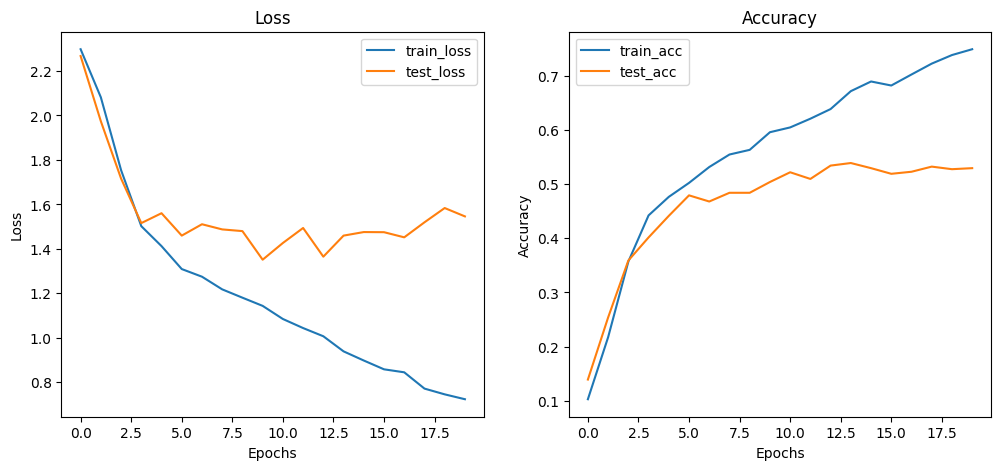

In [36]:
plot_loss_curves(model_0_results)